1. Computing Random Vectors for training the neural network based pricer

References: <br>
https://srdas.github.io/Papers/BlackScholesNN.pdf <br>
https://srdas.github.io/DLBook/DeepLearningWithPython.html#option-pricing

It is linear homogenous in the stock price  S  and strike price  K.

https://stackoverflow.com/questions/58839721/how-to-define-a-loss-function-in-pytorch-with-dependency-to-partial-derivatives <br> - Check this for custom loss function <br>
https://www.kdnuggets.com/2017/08/37-reasons-neural-network-not-working.html
<br>
https://arxiv.org/pdf/1606.08415.pdf -- GELU <br>
https://discuss.pytorch.org/t/how-to-restrict-the-neural-network-gradient-value-w-r-t-some-input/58440/5

In [ ]:
import numpy as np
import pandas as pd
from math import exp
from math import log as ln
from scipy.stats import norm
from random import random
from csv import writer as csvwriter

In [ ]:
''' Optional step:  To mount and use files in Google Drive'''
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainFile = "/content/drive/My Drive/Code/generatedTrainData.csv"
valFile   = "/content/drive/My Drive/Code/generatedValData.csv"
msFile    = "/content/drive/My Drive/Code/meansAndStds.csv"
totalSize = 30000

'''
Stock price by Strike price (S) 0.6   - 1.4
Maturity                    (T) 1 day - 3 years
Risk free rate              (r) 1%    - 7%
Volatility                  (σ) 2%    - 90%
Hurst Parameter             (H) 0     - 1            
'''

randS = lambda : 0.6 + random()*0.8
randτ = lambda : 1/365 + random()*1094/365
randR = lambda : 0.01 + random()*0.06
randσ = lambda : 0.02 + random()*0.88
randH = lambda : random()

In [ ]:
Φ = norm.cdf

d1 = lambda S,K,r,τ,σ,H : (ln(S/K) + r*τ + 0.5*(σ**2)*(τ**(2*H)))/(σ*(τ**H))

d2 = lambda S,K,r,τ,σ,H : d1(S,K,r,τ,σ,H) - σ*(τ**H)

def Cf(S,K,r,τ,σ,H):    
  ''' fractional Black-Scholes value of a European call option '''
  return S*Φ(d1(S,K,r,τ,σ,H)) - (K*exp(-r*τ))*Φ(d2(S,K,r,τ,σ,H))

In [ ]:
def createData( dataSize ):
  ''' Create <dataSize> number of fBSM entries in the <dataFile> '''
  i, data = 0, np.zeros((30000,6))
  while i < dataSize:
    S,r,τ,σ,H = randS(),randR(),randτ(),randσ(),randH()
    C = Cf(S,1,r,τ,σ,H)
    if C < 0.01: continue
    data[i,:] = [S,r,τ,σ,H,C]
    i += 1
  return data

def createDataFile( dataFile, data ):
  ''' Create <dataSize> number of fBSM entries in the <dataFile> '''
  pd.DataFrame(data).to_csv(dataFile, header = ["S","r","τ","σ","H","C"], index = None)
  print(f"File <{dataFile}> created with {len(data)} entries")

In [ ]:
data = createData( totalSize )
means = np.array(list(map(lambda i: data[:,i].mean(), range(0,6))))
stds = np.array(list(map(lambda i: data[:,i].std(), range(0,6))))
normData = (data - means)/stds
minCost = min(normData[:,-1]) 
print(minCost) #-1.472140313637543
normData[:,-1] = normData[:,-1] - minCost - 0.5

-1.472140313637543


In [ ]:
''' One time activity: Generate the training and validation data. Uncomment and execute if not already present '''
split = int(0.8*totalSize)
#createDataFile( trainFile, normData[:split])
#createDataFile( valFile, normData[split:])
#createDataFile( msFile, np.array([means,stds]) )

File </content/drive/My Drive/Code/generatedTrainData.csv> created with 24000 entries
File </content/drive/My Drive/Code/generatedValData.csv> created with 6000 entries
File </content/drive/My Drive/Code/meansAndStds.csv> created with 2 entries


**Neural Network design and training**

In [ ]:
import torch
import datetime
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [ ]:
class fBMDataset(Dataset):
    
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item[:-1].values).float()
        Y = item[-1]
        return X, Y

In [ ]:
class fBMDatasetWithK(Dataset):
    
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.data.insert(0,"K",np.random.normal(0,1,len(self.data)))
        self.data["S"] = self.data["S"]*self.data["K"]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item[:-1].values).float()
        Y = item[-1]
        return X, Y

In [ ]:
trainFile = "/content/drive/My Drive/Code/generatedTrainData.csv"
valFile   = "/content/drive/My Drive/Code/generatedValData.csv"
msFile    = "/content/drive/My Drive/Code/meansAndStds.csv"

msContents = pd.read_csv(msFile)
d_means, d_stds = msContents.iloc[0].values, msContents.iloc[1].values

In [ ]:
trainDataSet = fBMDataset(trainFile)
valDataSet = fBMDataset(valFile)

In [ ]:
def melu(x, α=0.49):
  ''' Custom ELU activation function which ensures C2 '''
  multiplier = (x>0)*((x/2 + 1 - 2*α)/(x + 1/α - 2)) + (x<0)*1
  return F.elu(x) * multiplier

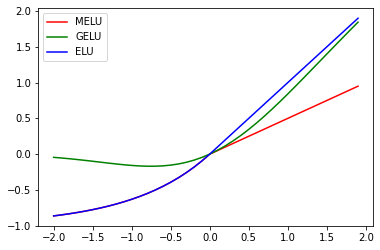

In [ ]:
def plotActivations():
  ''' Diagnostic method to plot melu '''
  x = torch.Tensor(np.arange(-2,2,0.1))
  y = melu(x)
  plt.plot(x.numpy(),y.numpy(),'r',label="MELU")
  y = F.gelu(x)
  plt.plot(x.numpy(),y.numpy(),'g',label="GELU")
  y = F.elu(x)
  plt.plot(x.numpy(),y.numpy(),'b',label="ELU")
  plt.legend(loc="upper left")

plotActivations()

In [ ]:
def logModelDetails(model):
  ''' log a Pytorch model specs '''
  print(model)
  params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f"Total trainable paramters: {params}")

class Pricer (nn.Module):
  ''' The pricer neural network functional '''

  def __init__(self,inLength,outLength):
    super().__init__()
    self.fc1 = nn.Linear(inLength,128) 
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 128)
    self.final = nn.Linear(128,outLength)

  def forward(self, x):
    out = self.fc1(x)
    out = F.dropout(out, p = 0.2)
    out = F.gelu(self.fc2(out))
    out = F.dropout(out, p = 0.2)
    out = F.gelu(self.fc3(out))
    out = F.dropout(out, p = 0.2)
    out = F.softplus(self.final(out)) - 0.5
    return out

In [ ]:
def validate(model, val_loader, loss_fn):
  ''' Method which accepts the model as well as train and validation data loaders and logs the accuracy '''
  loss_val = 0.0
  with torch.no_grad():
    for Xs, Ys in val_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.float().to(device=device)        
      outputs = model(Xs)
      loss_val += loss_fn(outputs, Ys.view(-1,1)).item()
  print(f"Validation Loss {round(loss_val/len(val_loader),5)}")

def training_loop_mse(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
  ''' Method to execute the training '''
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for Xs, Ys in train_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.float().to(device=device)
      outputs = model(Xs)
      loss = loss_fn(outputs, Ys.view(-1,1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print(f'{datetime.datetime.now()} Epoch {epoch} \nTraining Loss {round(loss_train/len(train_loader),5)}')
    validate(model, val_loader, loss_fn)

In [ ]:
model = Pricer(5,1).to(device=device)
logModelDetails(model)


Pricer(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)
Total trainable paramters: 33921


In [ ]:
# Saving or Loading Models

#torch.save(model.state_dict(), "/content/drive/My Drive/Code/model_14_epochs.pt")
model.load_state_dict(torch.load("/content/drive/My Drive/Code/MSE-GELU/model_14_mse_epochs.pt", map_location=device))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainLoader = torch.utils.data.DataLoader(trainDataSet, 64, shuffle= True)
valLoader = torch.utils.data.DataLoader(valDataSet, 64, shuffle= True)

In [ ]:
loss_fn = nn.MSELoss()
training_loop_mse (
  n_epochs = 1,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = trainLoader,
  val_loader = valLoader
  )

2020-07-20 06:00:23.836664 Epoch 1 
Training Loss 0.01338
Validation Loss 0.01318


In [ ]:
def getTrainAndValOutputs( model, train_loader, val_loader ):
  yActualTrain, yActualVal = np.zeros(24000), np.zeros(6000)
  yPredTrain, yPredVal = np.zeros(24000), np.zeros(6000)
  with torch.no_grad():
    model.eval()
    i = 0
    for Xs, Ys in train_loader:
      Xs = Xs.to(device=device)
      yPredTrain[i:i+len(Ys)] = model(Xs).numpy().flatten()
      yActualTrain[i:i+len(Ys)] = Ys.numpy().flatten()
      i += len(Ys)
    i = 0
    for Xs, Ys in val_loader:
      Xs = Xs.to(device=device)
      yPredVal[i:i+len(Ys)] = model(Xs).numpy().flatten()
      yActualVal[i:i+len(Ys)] = Ys.numpy().flatten()
      i += len(Ys)
  return yActualTrain, yActualVal, yPredTrain, yPredVal

def plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal):
  ''' Plot both train and validation predictions '''
  plt.figure(figsize=(18, 6))
  plt.subplot(131)
  plt.scatter(yActualTrain, yPredTrain, s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("In sample")
  plt.subplot(132)
  plt.scatter(yActualVal,yPredVal, s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Out of sample")
  plt.show()

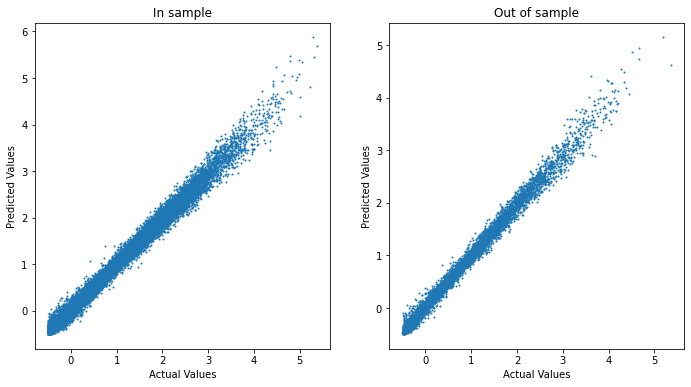

In [ ]:
#--- MSE-GELU ---
yActualTrain, yActualVal, yPredTrain, yPredVal = getTrainAndValOutputs( model, trainLoader, valLoader)
plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
trainDataSet = fBMDatasetWithK(trainFile)
valDataSet = fBMDatasetWithK(valFile)

In [ ]:
model = Pricer(6,1).to(device=device)
logModelDetails(model)

Pricer(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)
Total trainable paramters: 34049


In [ ]:
def training_loop_mse_k(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
  ''' Method to execute the training '''
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for Xs, Ys in train_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.float().to(device=device)
      outputs = model(Xs)
      loss = loss_fn(outputs, Ys.view(-1,1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print(f'{datetime.datetime.now()} Epoch {epoch} \nTraining Loss {round(loss_train/len(train_loader),5)}')
    validate(model, val_loader, loss_fn)

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, 64, shuffle= True)
valLoader = torch.utils.data.DataLoader(valDataSet, 64, shuffle= True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model.train()

Pricer(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
training_loop_mse_k (
  n_epochs = 1,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = trainLoader,
  val_loader = valLoader
  )

2020-07-24 10:21:34.452645 Epoch 1 
Training Loss 0.05955
Validation Loss 0.06159


In [ ]:
# Saving or Loading Models

#torch.save(model.state_dict(), "/content/drive/My Drive/Code/MSE-GELU-K/model_K_21_epochs.pt")
model.load_state_dict(torch.load("/content/drive/My Drive/Code/MSE-GELU-K/model_K_17_epochs.pt", map_location=device))

<All keys matched successfully>

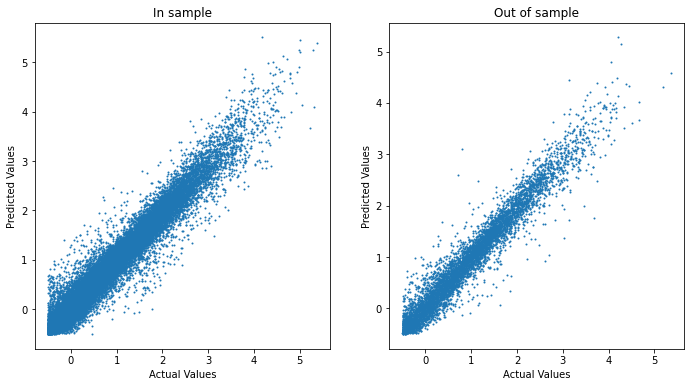

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = getTrainAndValOutputs( model, trainLoader, valLoader)
plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
def pf(x, λ=1, m=3):
  ''' Penalty function for applying soft constraints of no arbitrage conditions '''
  fn = λ*(x**m)
  return fn*(fn>0)

def training_loop_penalty(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
  ''' Method to execute the training '''
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for Xs, Ys in train_loader:
      Xs = Variable(Xs.to(device=device), requires_grad=True)
      Ys = Variable(Ys.float().to(device=device), requires_grad=True)
      outputs = model(Xs)
      dCdx = torch.autograd.grad(outputs, Xs, grad_outputs=outputs.data.new(outputs.shape).fill_(1), create_graph=True, retain_graph=True)[0]
      d2Cdx2 = torch.autograd.grad(dCdx, Xs, grad_outputs=dCdx.data.new(dCdx.shape).fill_(1), create_graph=True, retain_graph=True)[0]
      K, T = Xs[:,0], Xs[:,3]
      dCdk, dCdt = dCdx[:,0], dCdx[:,3]
      d2Cdk2 = d2Cdx2[:,0]
      penalty = torch.sum(pf(-(K**2)*(d2Cdk2))) + torch.sum(pf(-T*dCdt)) + torch.sum(pf(K*dCdk))
      mse = loss_fn(outputs, Ys.view(-1,1))
      loss = mse + penalty
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print(f'{datetime.datetime.now()} Epoch {epoch} \nTraining Loss {round(loss_train/len(train_loader),5)}')
    validate(model, val_loader, loss_fn)

In [ ]:
model = Pricer(6,1).to(device=device)
logModelDetails(model)

Pricer(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)
Total trainable paramters: 34049


In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, 64, shuffle= True)
valLoader = torch.utils.data.DataLoader(valDataSet, 64, shuffle= True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
# Saving or Loading Models

#torch.save(model.state_dict(), "/content/drive/My Drive/Code/Penalty-GELU/model_70_epochs.pt")
model.load_state_dict(torch.load("/content/drive/My Drive/Code/Penalty-GELU/model_70_epochs.pt", map_location=device))

<All keys matched successfully>

In [ ]:
model.train()

Pricer(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
training_loop_penalty (
  n_epochs = 2,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = trainLoader,
  val_loader = valLoader
  )

2020-07-25 17:22:28.582971 Epoch 1 
Training Loss 0.33446
Validation Loss 0.31079
2020-07-25 17:22:53.659540 Epoch 2 
Training Loss 0.35248
Validation Loss 0.28535


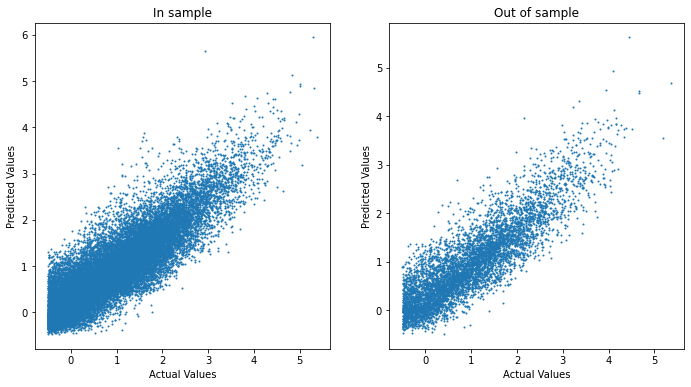

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = getTrainAndValOutputs( model, trainLoader, valLoader)
plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
valPredictionPath = "/content/drive/My Drive/Code/cannVal.csv"
trainPredictionPath = "/content/drive/My Drive/Code/cannTrain.csv"

In [ ]:
# Saving the inverse model dataset
'''
trainLoader = torch.utils.data.DataLoader(trainDataSet, 64, shuffle= False)
valLoader = torch.utils.data.DataLoader(valDataSet, 64, shuffle= False)
_, _, yPredTrain, yPredVal = getTrainAndValOutputs( model, trainLoader, valLoader)

pd.DataFrame(yPredTrain).to_csv(trainPredictionPath, header = ["Cann"], index = None)
pd.DataFrame(yPredVal).to_csv(valPredictionPath, header = ["Cann"], index = None)
'''

In [ ]:
class fBMDatasetInverse(Dataset):
    
    def __init__(self, data_path, cann_path ):
        original = pd.read_csv(data_path)
        cann = pd.read_csv(cann_path)
        self.data = pd.concat([cann, original], axis=1).drop(["C"], axis=1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item[:-2].values).float()
        Y = torch.from_numpy(item[-2:].values).float()
        return X, Y

In [ ]:
iTrainDataSet = fBMDatasetInverse(trainFile, trainPredictionPath)
iValDataSet = fBMDatasetInverse(valFile, valPredictionPath)

In [ ]:
model = Pricer(4,2).to(device=device)
logModelDetails(model)

Pricer(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=2, bias=True)
)
Total trainable paramters: 33922


In [ ]:
trainLoader = torch.utils.data.DataLoader(iTrainDataSet, 64, shuffle= True)
valLoader = torch.utils.data.DataLoader(iValDataSet, 64, shuffle= True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def iValidate(model, val_loader, loss_fn):
  ''' Method which accepts the model as well as train and validation data loaders and logs the accuracy '''
  loss_val = 0.0
  with torch.no_grad():
    for Xs, Ys in val_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.to(device=device)        
      outputs = model(Xs)
      loss_val += loss_fn(outputs, Ys).item()
  print(f"Validation Loss {round(loss_val/len(val_loader),5)}")

def i_training_loop_mse(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
  ''' Method to execute the training '''
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for Xs, Ys in train_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.to(device=device)
      outputs = model(Xs)
      loss = loss_fn(outputs, Ys)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print(f'{datetime.datetime.now()} Epoch {epoch} \nTraining Loss {round(loss_train/len(train_loader),5)}')
    iValidate(model, val_loader, loss_fn)

In [ ]:
loss_fn = nn.MSELoss()
i_training_loop_mse (
  n_epochs = 4,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = trainLoader,
  val_loader = valLoader
  )

2020-07-26 18:04:49.801541 Epoch 1 
Training Loss 0.73726
Validation Loss 0.73134
2020-07-26 18:05:03.374605 Epoch 2 
Training Loss 0.73655
Validation Loss 0.73237
2020-07-26 18:05:16.864564 Epoch 3 
Training Loss 0.73652
Validation Loss 0.72988
2020-07-26 18:05:30.312303 Epoch 4 
Training Loss 0.73583
Validation Loss 0.7313


In [ ]:
# Saving or Loading Models

#torch.save(model.state_dict(), "/content/drive/My Drive/Code/Inverse-map/model_12_epochs.pt")
model.load_state_dict(torch.load("/content/drive/My Drive/Code/Inverse-map/model_12_epochs.pt", map_location=device))

<All keys matched successfully>

In [ ]:
def iGetTrainAndValOutputs( model, train_loader, val_loader ):
  yActualTrain, yActualVal = np.zeros((24000,2)), np.zeros((6000,2))
  yPredTrain, yPredVal = np.zeros((24000,2)), np.zeros((6000,2))
  with torch.no_grad():
    model.eval()
    i = 0
    for Xs, Ys in train_loader:
      Xs = Xs.to(device=device)
      yPredTrain[i:i+len(Ys)] = model(Xs).numpy()
      yActualTrain[i:i+len(Ys)] = Ys.numpy()
      i += len(Ys)
    i = 0
    for Xs, Ys in val_loader:
      Xs = Xs.to(device=device)
      yPredVal[i:i+len(Ys)] = model(Xs).numpy()
      yActualVal[i:i+len(Ys)] = Ys.numpy()
      i += len(Ys)
  return yActualTrain, yActualVal, yPredTrain, yPredVal


def iPlotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal):
  ''' Plot both train and validation predictions '''
  #  plt.figure(figsize=(18, 12))
  plt.figure()
  plt.subplot(2, 2, 1)
  plt.scatter(yActualTrain[:,0], yPredTrain[:,0], s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("In sample")
  plt.subplot(2, 2, 2)
  plt.scatter(yActualVal[:,0],yPredVal[:,0], s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Out of sample")
  plt.subplot(2, 2, 3)
  plt.scatter(yActualTrain[:,1], yPredTrain[:,1], s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("In sample")
  plt.subplot(2, 2, 4)
  plt.scatter(yActualVal[:,1],yPredVal[:,1], s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Out of sample")
  plt.show()

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = iGetTrainAndValOutputs( model, trainLoader, valLoader )

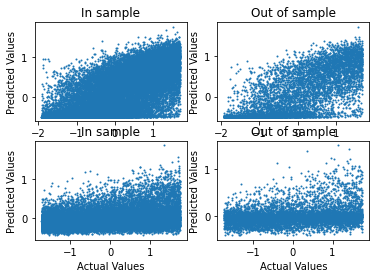

In [ ]:
iPlotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
class fBMDatasetInverseDirect(Dataset):
    
    def __init__(self, data_path ):
        self.data = pd.read_csv(data_path)
        self.data = self.data[["C","S","r","τ","σ","H"]]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item[:-2].values).float()
        Y = torch.from_numpy(item[-2:].values).float()
        return X, Y

In [ ]:
model = Pricer(4,2).to(device=device)
logModelDetails(model)
idTrainDataSet = fBMDatasetInverseDirect(trainFile)
idValDataSet = fBMDatasetInverseDirect(valFile)

trainLoader = torch.utils.data.DataLoader(iTrainDataSet, 64, shuffle= True)
valLoader = torch.utils.data.DataLoader(idValDataSet, 64, shuffle= True)

Pricer(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=2, bias=True)
)
Total trainable paramters: 33922


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.train()

Pricer(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
i_training_loop_mse (
  n_epochs = 6,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = trainLoader,
  val_loader = valLoader
  )

2020-07-26 18:52:08.244679 Epoch 1 
Training Loss 0.72723
Validation Loss 0.70934
2020-07-26 18:52:21.502106 Epoch 2 
Training Loss 0.7268
Validation Loss 0.70967
2020-07-26 18:52:34.817615 Epoch 3 
Training Loss 0.72697
Validation Loss 0.71021
2020-07-26 18:52:48.073911 Epoch 4 
Training Loss 0.72645
Validation Loss 0.70688
2020-07-26 18:53:01.371642 Epoch 5 
Training Loss 0.7263
Validation Loss 0.70733
2020-07-26 18:53:14.633188 Epoch 6 
Training Loss 0.7261
Validation Loss 0.70783


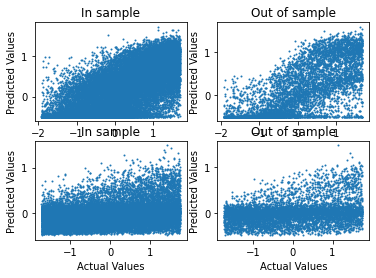

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = iGetTrainAndValOutputs( model, trainLoader, valLoader )
iPlotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
# Saving or Loading Models
torch.save(model.state_dict(), "/content/drive/My Drive/Code/direct-inverse/model_10_epochs.pt")
#model.load_state_dict(torch.load("/content/drive/My Drive/Code/direct-inverse/model_8_epochs.pt", map_location=device))